# CNN

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
# for visualization
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE
import sklearn.metrics as metrics
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
torch.manual_seed(1)    # reproducible

## Data

[Batch vs. epoch](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)

In [3]:
# Hyper Parameters
BATCH_SIZE = 100         # a number of samples processed before the model is updated.
DOWNLOAD_MNIST = False   # set to False if you have downloaded

In [4]:
# Mnist digits dataset
mnist_data = torchvision.datasets.MNIST(
    root='./data/mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to torch.FloatTensor 
                                                    # of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

torch.Size([60000, 28, 28])


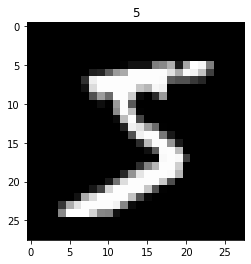

In [5]:
# plot one example
print(mnist_data.data.size())                 # (60000, 28, 28)
plt.imshow(mnist_data.data[0].numpy(), cmap='gray')
plt.title('%i' % mnist_data.targets[0])
plt.show()

In [6]:
mnist_data_x = Variable(torch.unsqueeze(mnist_data.data, dim=1)).type(torch.FloatTensor)[:2000]/255
mnist_data_y = mnist_data.targets[:2000]

In [7]:
# Fashion mnist dataset
fashion_train = torchvision.datasets.FashionMNIST(
    root='./data/fashion/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_MNIST,
)

torch.Size([60000, 28, 28])


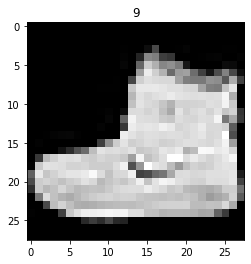

In [8]:
print(fashion_train.data.size())                 # (60000, 28, 28)
plt.imshow(fashion_train.data[0].numpy(), cmap='gray')
plt.title('%i' % fashion_train.targets[0])
plt.show()

In [9]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
fashion_loader = Data.DataLoader(dataset=fashion_train, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
# convert test data into Variable, pick 2000 samples to speed up testing
fashion_test = torchvision.datasets.FashionMNIST(root='./data/fashion', train=False)
fashion_test_x = Variable(torch.unsqueeze(fashion_test.data, dim=1)).type(torch.FloatTensor)[:2000]/255.   
# shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
fashion_test_y = fashion_test.targets[:2000]

## CNN

### Utils

#### Vizualization

In [11]:
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

In [12]:
def plot_confusion_matrix(actual_y, pred_y):
    confusion_matrix = metrics.confusion_matrix(actual_y, pred_y) 
    confusion_matrix = np.around(confusion_matrix / confusion_matrix.astype(np.float).sum(axis=1), 2)
    sns.heatmap(confusion_matrix, annot=True, vmin=0, vmax=1)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

### Architecture

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16 ,           # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (8, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (8, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 3, 1, 1),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.fc1 = nn.Linear(32 * 7 * 7, 16 * 7 * 7)     # fully connected layer, output 16 * 7 * 7
        self.drop = nn.Dropout2d(0.2)
        self.fc2 = nn.Linear(16 * 7 * 7, 4 * 7 * 7)      # fully connected layer, output 4 * 7 * 7
        self.out = nn.Linear(4 * 7 * 7, 10)              # fully connected layer, output 10 classes
        self.smax = nn.Softmax(-1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.out(x)
        output = self.smax(x)
        return output, x    # return x for visualization

In [14]:
cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=784, bias=True)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc2): Linear(in_features=784, out_features=196, bias=True)
  (out): Linear(in_features=196, out_features=10, bias=True)
  (smax): Softmax(dim=-1)
)


### Testing

In [15]:
test_output, last_layer = cnn(mnist_data_x)
pred_y = torch.max(test_output, 1)[1].data.squeeze()
accuracy = (pred_y == mnist_data_y).sum().item() / float(mnist_data_y.size(0))
print('accuracy: %.2f' % accuracy)

accuracy: 0.10


## Optimization

In [16]:
# Hyper Parameters
EPOCH = 3               # train the training data n times, to save time
LR = 0.001              # learning rate

In [17]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

### Training & testing

Epoch:  0 | train loss: 2.3019 | test accuracy: 0.20


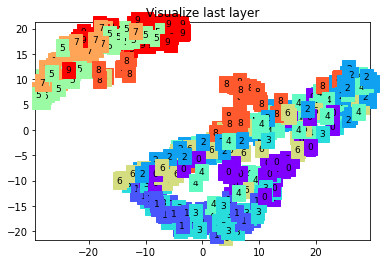

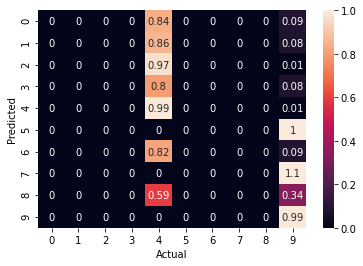

Epoch:  0 | train loss: 1.7542 | test accuracy: 0.75


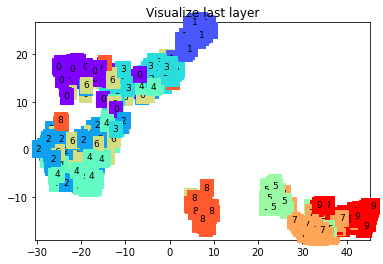

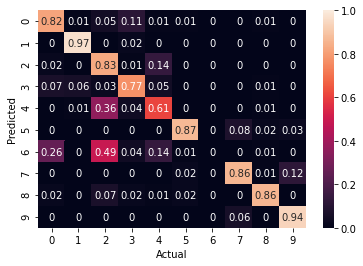

Epoch:  0 | train loss: 1.6590 | test accuracy: 0.76


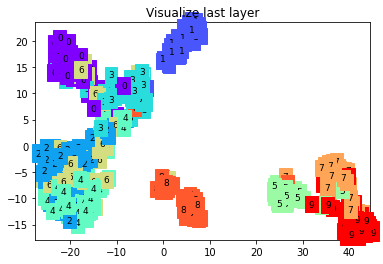

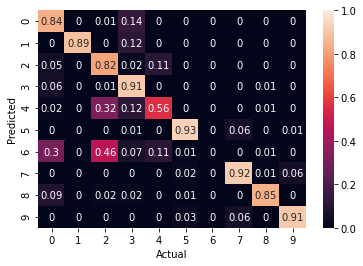

Epoch:  0 | train loss: 1.6382 | test accuracy: 0.80


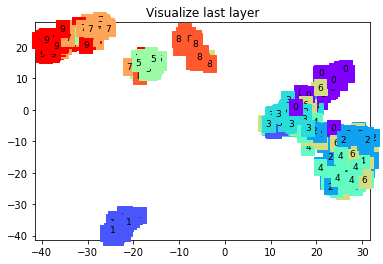

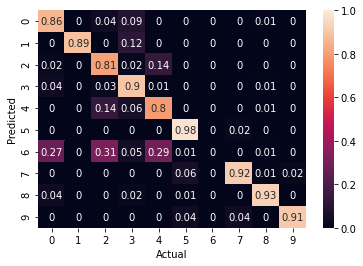

Epoch:  0 | train loss: 1.6540 | test accuracy: 0.81


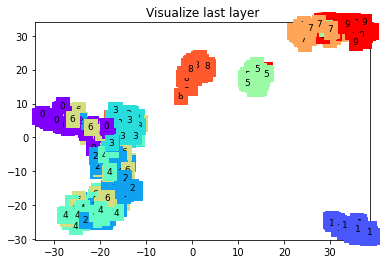

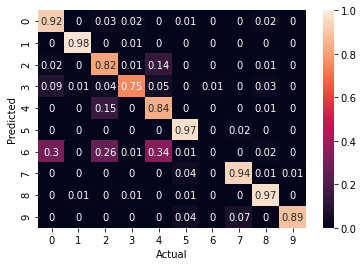

Epoch:  0 | train loss: 1.5885 | test accuracy: 0.82


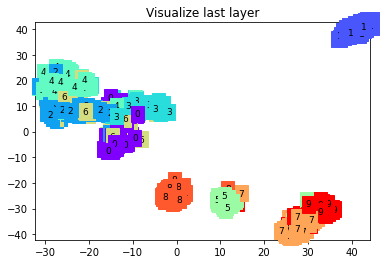

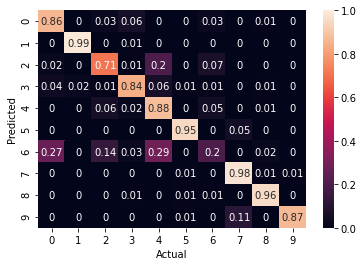

Epoch:  1 | train loss: 1.5589 | test accuracy: 0.85


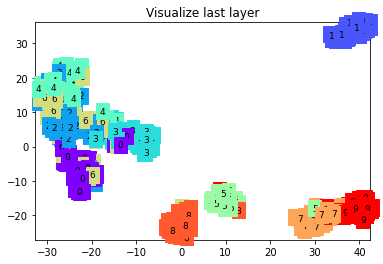

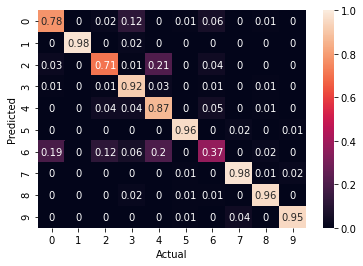

Epoch:  1 | train loss: 1.6785 | test accuracy: 0.85


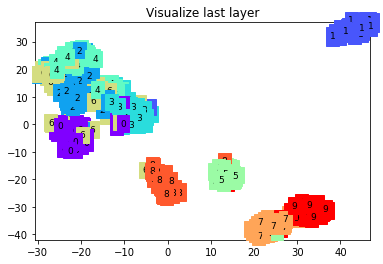

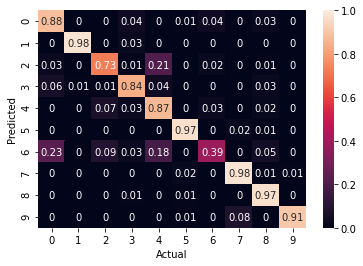

Epoch:  1 | train loss: 1.6245 | test accuracy: 0.85


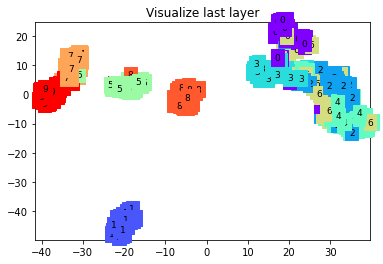

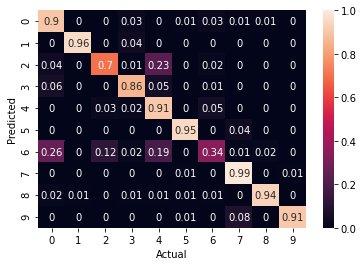

Epoch:  1 | train loss: 1.6364 | test accuracy: 0.86


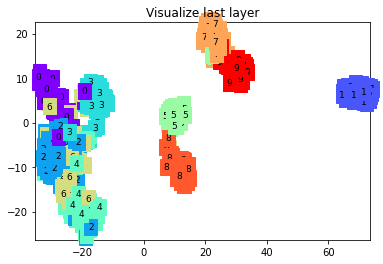

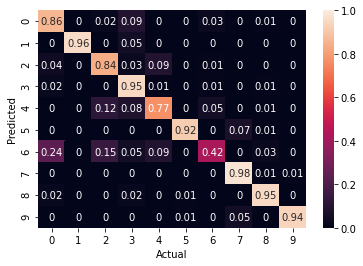

Epoch:  1 | train loss: 1.5778 | test accuracy: 0.86


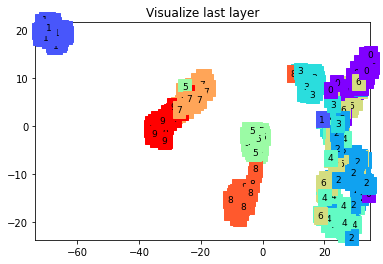

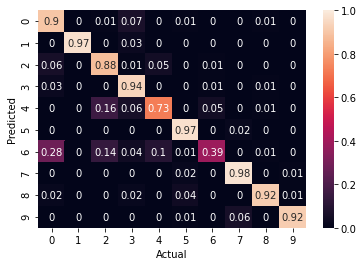

Epoch:  1 | train loss: 1.6013 | test accuracy: 0.87


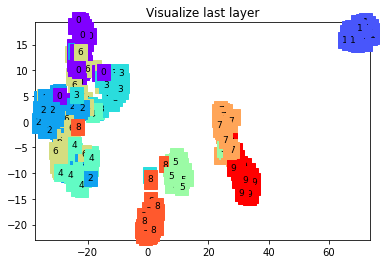

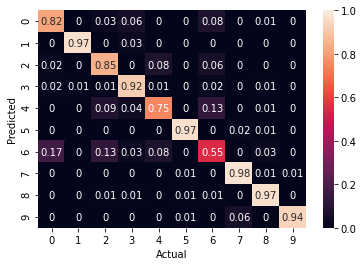

Epoch:  2 | train loss: 1.6103 | test accuracy: 0.86


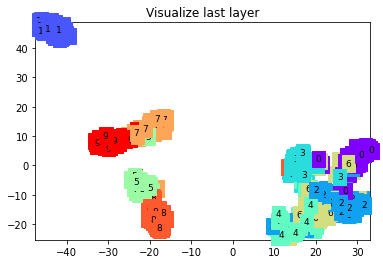

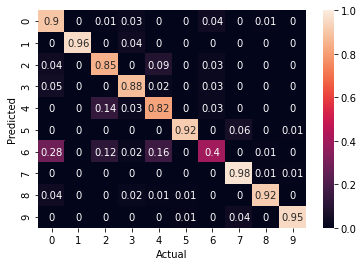

Epoch:  2 | train loss: 1.6081 | test accuracy: 0.87


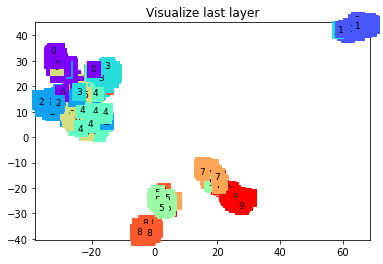

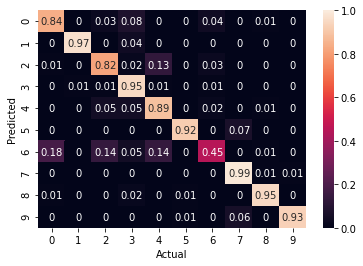

Epoch:  2 | train loss: 1.6006 | test accuracy: 0.88


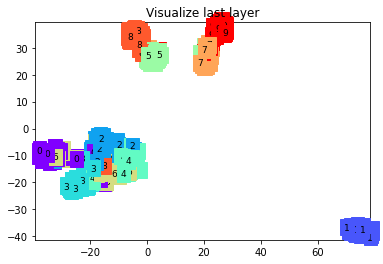

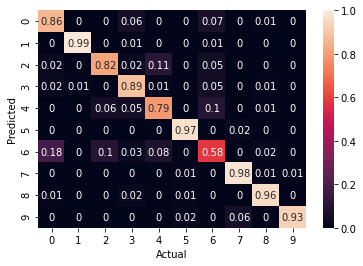

Epoch:  2 | train loss: 1.5860 | test accuracy: 0.87


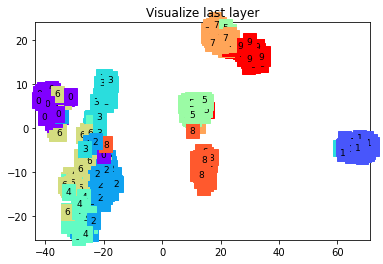

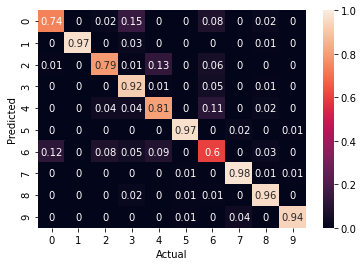

Epoch:  2 | train loss: 1.5882 | test accuracy: 0.87


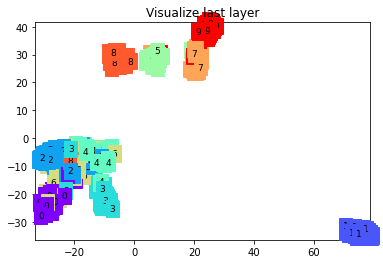

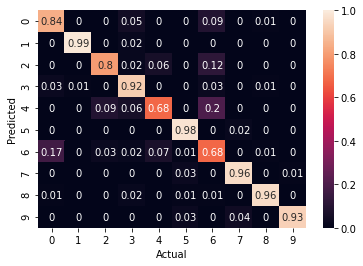

Epoch:  2 | train loss: 1.5843 | test accuracy: 0.86


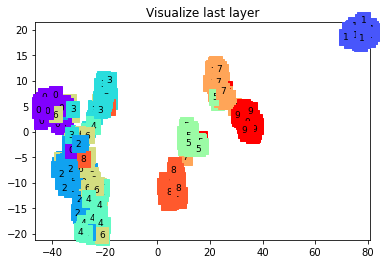

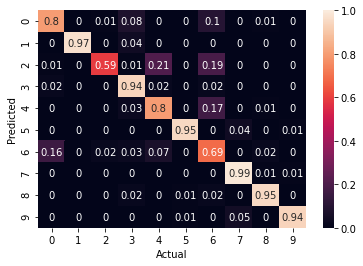

In [18]:
plt.ion()
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(fashion_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]            # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(fashion_test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == fashion_test_y).sum().item() / float(fashion_test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item(), '| test accuracy: %.2f' % accuracy)
            # Visualization of trained flatten layer (T-SNE)
            tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
            plot_only = 500
            low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
            labels = fashion_test_y.numpy()[:plot_only]
            plot_with_labels(low_dim_embs, labels)
            plot_confusion_matrix(fashion_test_y, pred_y)
plt.ioff()

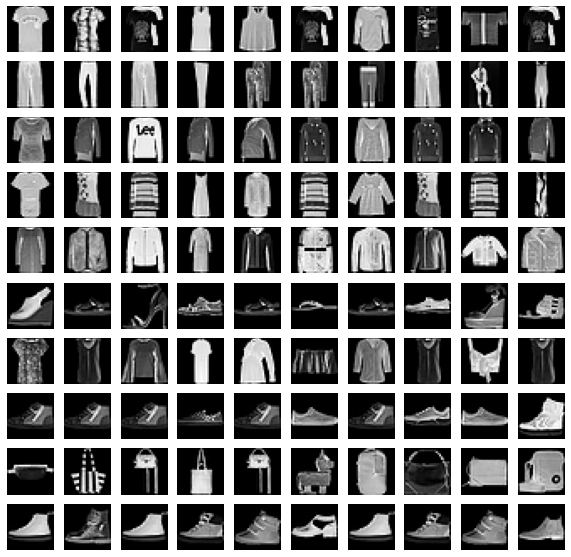

In [19]:
out = test_output.detach().numpy()
y = fashion_test_y.numpy()
x = fashion_test.data[:2000].numpy()
lout = out.shape[1]

f, axarr = plt.subplots(lout,lout, figsize=(10,10))
for i in range(lout):
    for j in range(lout):
        axarr[i,j].imshow(x[y==i][np.argmax(out[y==i][:, j])], cmap='gray')
        axarr[i,j].axis('off')